In [9]:
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
%matplotlib inline

from sklearn.preprocessing import RobustScaler

# import basic libraries 
import h5py
import pandas as pd

from keras.models import Model
from keras.layers import Input, add
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils


In [11]:
filename = "/uscms/home/jpearkes/eos/forAda/scouting_nano.root"
file = uproot.open(filename)

jet_pt = file["Events"]["L1Jet_pt"].array()
jet_eta = file["Events"]["L1Jet_eta"].array()
jet_phi = file["Events"]["L1Jet_phi"].array()



In [20]:
jet_pt = np.asarray(ak.fill_none(ak.pad_none(jet_pt, 4, clip=True), 0.0))
jet_eta = np.asarray(ak.fill_none(ak.pad_none(jet_eta, 4, clip=True), 0.0))
jet_phi = np.asarray(ak.fill_none(ak.pad_none(jet_phi, 4, clip=True), 0.0))

jet_pt.shape

(431555, 4)

In [23]:
dataset = np.hstack([jet_pt,jet_eta,jet_phi])
dataset.shape

(431555, 12)

In [25]:
dataset_size = dataset.shape[0]
data_train = dataset[0:int(dataset_size/2)]
data_valid = dataset[int(dataset_size/2):int(dataset_size/4*3)] # used for tuning hyper-parameters
data_test = dataset[int(dataset_size/4*3):] # hold out for now

print(data_train.shape,data_test.shape, data_valid.shape)



(215777, 12) (107889, 12) (107889, 12)


In [28]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        print(batch)
        dim = tf.shape(z_mean)[1]
        print(dim)
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
#Encoder

latent_dim = 4

encoder_inputs = keras.Input(shape=(12))
x = layers.Normalization(mean=np.mean(data_train,axis=0),variance=np.std(data_train,axis=0), axis=-1, invert = False)(encoder_inputs)
x1 = layers.Dense(32, activation="relu")(x)
x2 = layers.Dense(16, activation="relu")(x1)
x3 = layers.Dense(8, activation="relu")(x2)
z_mean = layers.Dense(latent_dim, name="z_mean")(x3)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x3)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

#Decoder

latent_inputs = keras.Input(shape=(latent_dim,))
x4 = layers.Dense(16, activation="relu")(latent_inputs)
norm_layer_1 = layers.BatchNormalization(name="norm_1")(x4)
x5 = layers.Dense(32, activation="relu")(norm_layer_1)
norm_layer_2 = layers.BatchNormalization(name="norm_2")(x5)
x6 = layers.Dense(64, activation="relu")(norm_layer_2)
norm_layer_3 = layers.BatchNormalization(name="norm_3")(x6)
x7 = layers.Dense(128, activation="relu")(norm_layer_3)
x8 = layers.Dense(12,kernel_initializer='zeros', activation='linear')(x7)
decoder_outputs = tf.keras.layers.Normalization(mean=np.mean(data_train,axis=0),variance=np.std(data_train,axis=0), axis=-1, invert = True)(x8)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

#Build Model

class VAE(keras.Model):
    def __init__(self, encoder, decoder,alpha = 1, beta = 0.001, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
        self.reco_scale = alpha * (1 - beta)
        self.kl_scale = beta
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.total_val_loss_tracker = keras.metrics.Mean(name="total_val_loss")
        self.reconstruction_val_loss_tracker = keras.metrics.Mean(name="val_reco_loss")
        self.kl_val_loss_tracker = keras.metrics.Mean(name="val_kl_loss")


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    

    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            #MSE = keras.losses.MeanSquaredLogarithmicError(reduction="auto", name="mean_squared_error")
            #MSE = keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
            MSE = keras.losses.MeanSquaredError(reduction="none", name="mean_squared_error")
            reconstruction_loss = self.reco_scale * tf.reduce_mean(tf.reduce_sum(MSE(data,reconstruction)))
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = self.kl_scale * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
            
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        
        #MSE = keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
        MSE = keras.losses.MeanSquaredError(reduction="none", name="mean_squared_error")
        reconstruction_loss = self.reco_scale* tf.reduce_mean(tf.reduce_sum(MSE(data,reconstruction)))
                    
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = self.kl_scale * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        
        total_loss = reconstruction_loss + kl_loss
        
        self.total_val_loss_tracker.update_state(total_loss)
        self.reconstruction_val_loss_tracker.update_state(reconstruction_loss)
        self.kl_val_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_val_loss_tracker.result(),
            "reco_loss": self.reconstruction_val_loss_tracker.result(),
            "kl_loss": self.kl_val_loss_tracker.result()

      }

Tensor("sampling_1/strided_slice:0", shape=(), dtype=int32)
Tensor("sampling_1/strided_slice_1:0", shape=(), dtype=int32)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 normalization_3 (Normalization  (None, 12)          0           ['input_5[0][0]']                
 )                                                                                                
                                                                                                  
 dense_8 (Dense)                (None, 32)           416         ['normalization_3[0][0]']        
                                                                     

In [29]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0, patience=5, verbose = 1,restore_best_weights=True)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0001,clipnorm=10.0))
history = vae.fit(data_train, validation_data = (data_valid, data_valid), epochs=10, batch_size=16, callbacks = [callback],shuffle=False)

Epoch 1/500
Tensor("encoder/sampling_1/strided_slice:0", shape=(), dtype=int32)
Tensor("encoder/sampling_1/strided_slice_1:0", shape=(), dtype=int32)
Tensor("encoder/sampling_1/strided_slice:0", shape=(), dtype=int32)
Tensor("encoder/sampling_1/strided_slice_1:0", shape=(), dtype=int32)
13469/13487 [============================>.] - ETA: 0s - loss: 10098.6763 - reconstruction_loss: 3596.1084 - kl_loss: 0.9002Tensor("encoder/sampling_1/strided_slice:0", shape=(), dtype=int32)
Tensor("encoder/sampling_1/strided_slice_1:0", shape=(), dtype=int32)
13487/13487 [==============================] - 41s 2ms/step - loss: 10089.5141 - reconstruction_loss: 3591.5012 - kl_loss: 0.9003 - val_loss: 180.0418 - val_reco_loss: 178.9431 - val_kl_loss: 1.0985
Epoch 2/500
10781/13487 [======================>.......] - ETA: 5s - loss: 155.9955 - reconstruction_loss: 117.4093 - kl_loss: 1.0943

KeyboardInterrupt: 

In [30]:
z_mean, z_log_var, z = vae.encoder.predict(data_valid)
output = vae.decoder.predict(z)

Tensor("encoder/sampling_1/strided_slice:0", shape=(), dtype=int32)
Tensor("encoder/sampling_1/strided_slice_1:0", shape=(), dtype=int32)
3372/3372 [==============================] - 3s 739us/step


In [31]:
print(history.history.keys())

plt.plot(history.history['loss'],label="train")
plt.plot(history.history['val_loss'],label="validation")
#plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( loc='upper right',frameon = False)
plt.show()

NameError: name 'history' is not defined

(107889, 4, 3) (107889, 12) (107889, 12)


Text(0.5, 1.0, '1st Jet')

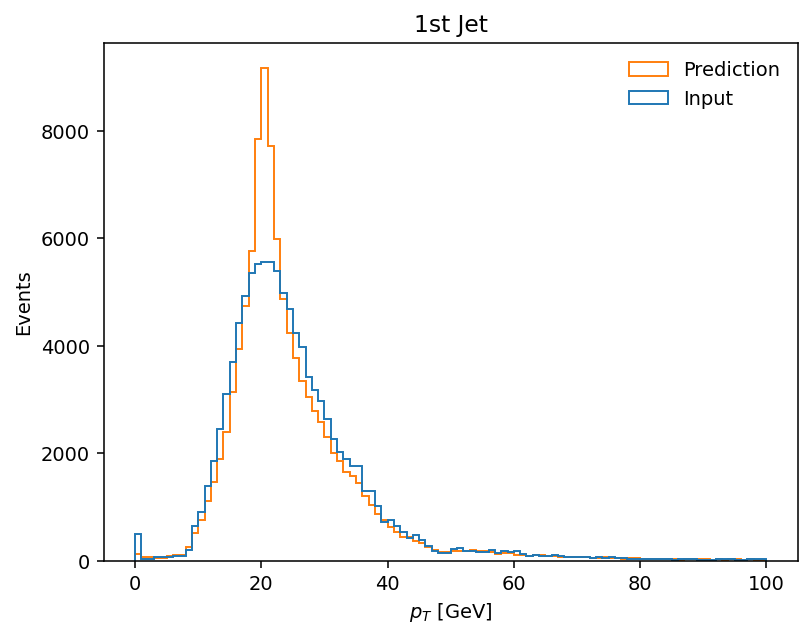

In [43]:
decoded_data = output.reshape(output.shape[0], 4,3)
data_valid_reshaped = data_valid.reshape(data_valid.shape[0], 4,3)

print(decoded_data.shape,data_test.shape, data_valid.shape)

#Jet Pt plot
plt.figure()
plt.rcParams['figure.dpi'] = 140
plt.hist([data_valid_reshaped[:,0,0],decoded_data[:,0,0]],bins=100,histtype='step',range = (0,100), label = ['Input','Prediction'])
plt.xlabel(r"$p_T$ [GeV]")
plt.ylabel("Events")
plt.legend(frameon = False)
plt.title('1st Jet')



# Notes

- Might need to check the dataset shapes here
- What is the training step doing? 
- What are hyperparameters and what happen when you change them? 
- How well does the input compare with the predictions? 
- What is overtraining and how can you combat it? 
- Can you plot eta and phi input vs predictions too? 
- Can you add in electrons and muons into the training too? Do the predictions improve or get worse? 